In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.tree import DecisionTreeClassifier
from natsort import natsorted
import metrics

In [2]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\default_dataset.csv")

for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Column {col} has {df[col].isna().sum()} missing values")
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

df.head()

Column person_emp_length has 895 missing values
Column loan_int_rate has 3116 missing values


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Explore binning options

#### Decision tree for binning

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from natsort import natsorted

def create_binned_feature(df, feature, target, max_leaf_nodes=6, min_samples_leaf=0.05, random_state=42):
    """
    Create bins using decision tree with enforced monotonicity and minimum sample size per bin.
    """
    # Force 5% of the samples in each bin
    min_samples_leaf_count = int(min_samples_leaf * len(df))  # 5% of all samples
    
    # Fit decision tree with monotonicity constraints (assuming increasing order)
    tree = DecisionTreeClassifier(
        max_leaf_nodes=max_leaf_nodes, 
        min_samples_leaf=min_samples_leaf_count, 
        random_state=random_state,
        criterion='entropy'
    )
    
    tree.fit(df[[feature]], df[target])
    
    # Get bin assignments
    df_copy = df.copy()
    df_copy['bin'] = tree.apply(df[[feature]])
    
    # Create bin labels with intervals
    bin_stats = df_copy.groupby('bin')[feature].agg(['min', 'max']).round(2)
    bin_labels = {
        row_idx: f'[{row["min"]:.2f}-{row["max"]:.2f}]'
        for row_idx, row in bin_stats.iterrows()
    }
    
    # Create reverse mapping for later use
    reverse_bin_labels = {v: k for k, v in bin_labels.items()}
    
    # Map numeric bins to interval labels
    df_copy['bin_label'] = df_copy['bin'].map(bin_labels)
    
    return df_copy, bin_stats, reverse_bin_labels

def calculate_woe(df, feature, target, event=1, plot=False, figsize=(12, 6), bin_stats=None, reverse_mapping=None):
    """
    Calculate and optionally plot Weight of Evidence (WoE) for a feature.
    """
    try:
        # Validate inputs
        if not all(col in df.columns for col in [feature, target]):
            raise ValueError(f"Columns {feature} and/or {target} not found in DataFrame")
            
        if not set(df[target].unique()).issubset({0, 1}):
            raise ValueError("Target variable should be binary (0/1)")
            
        # Calculate frequencies
        cross_tab = pd.crosstab(df[feature], df[target])
        
        # Calculate proportions
        event_prop = cross_tab[event] / cross_tab[event].sum()
        non_event_prop = cross_tab[1 - event] / cross_tab[1 - event].sum()
        
        # Calculate WoE
        woe = np.log(non_event_prop / event_prop)
        
        # Create summary DataFrame
        summary = pd.DataFrame({
            'non_event_count': cross_tab[1 - event],
            'event_count': cross_tab[event],
            'non_event_rate': non_event_prop,
            'event_rate': event_prop,
            'WoE': woe
        }).round(4)
        
        # Calculate Information Value (IV)
        summary['IV'] = (non_event_prop - event_prop) * woe
        total_iv = summary['IV'].sum()
        
        # Sort by WoE in descending order
        summary = summary.sort_values('WoE', ascending=False)
        
        if plot:
            fig, ax1 = plt.subplots(figsize=figsize)
            
            # Bar plot for event and non-event counts
            counts = pd.DataFrame({
                'Non-Event': summary['non_event_count'],
                'Event': summary['event_count']
            })
            counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
            
            # Set x-labels showing the intervals
            plt.xticks(range(len(summary.index)), summary.index, rotation=45, ha='right')
            
            ax1.set_xlabel("Interest Rate Bins")
            ax1.set_ylabel("Number of Observations")
            ax1.set_title(f"Distribution and WoE Analysis\n(Sorted by WoE)")
            
            # Create second y-axis for WoE values
            ax2 = ax1.twinx()
            ax2.plot(range(len(summary.index)), summary['WoE'].values, 
                    marker='o', color='black', linestyle='-', linewidth=2, 
                    label="Weight of Evidence")
            
            ax2.set_ylabel("Weight of Evidence")
            
            # Show legends
            ax1.legend(["Non-Event (0)", "Event (1)"], loc="upper left")
            ax2.legend(loc="upper right")
            
            plt.tight_layout()
            plt.show()
        
        return summary, total_iv
        
    except Exception as e:
        print(f"Error in WoE calculation: {str(e)}")
        return None, None


In [113]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

def test_optimal_max_leaf_nodes(df, feature, target, max_leaf_nodes_range, min_samples_leaf=0.05, random_state=42):
    """
    Test various values for max_leaf_nodes in decision tree and evaluate performance.
    """
    min_samples_leaf_count = int(min_samples_leaf * len(df))  # 5% of all samples
    best_score = -np.inf
    best_max_leaf_nodes = None
    results = []

    # Iterate over the range of max_leaf_nodes to find the best value
    for max_leaf_nodes in max_leaf_nodes_range:
        # Create the model with the current max_leaf_nodes and min_samples_leaf
        tree = DecisionTreeClassifier(
            max_leaf_nodes=max_leaf_nodes,
            min_samples_leaf=min_samples_leaf_count,
            random_state=random_state,
            criterion='entropy'
        )

        # Perform cross-validation to test the model performance
        scores = cross_val_score(tree, df[[feature]], df[target], cv=5, scoring='roc_auc')  # AUC is commonly used
        mean_score = np.mean(scores)

        # Track the best score and corresponding max_leaf_nodes
        results.append((max_leaf_nodes, mean_score))
        if mean_score > best_score:
            best_score = mean_score
            best_max_leaf_nodes = max_leaf_nodes

    # Print the results
    print("Results for different max_leaf_nodes values (ROC AUC):")
    for max_leaf_nodes, score in results:
        print(f"Max leaf nodes: {max_leaf_nodes}, ROC AUC: {score:.4f}")

    print(f"Best max_leaf_nodes: {best_max_leaf_nodes} with ROC AUC: {best_score:.4f}")
    
    return best_max_leaf_nodes, best_score, results

# Example usage
max_leaf_nodes_range = [2,3,4, 5,6,7,8,9, 10]  # Try different values
best_max_leaf_nodes, best_score, results = test_optimal_max_leaf_nodes(df, 'loan_percent_income', 'loan_status', max_leaf_nodes_range)

Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes: 2, ROC AUC: 0.6673
Max leaf nodes: 3, ROC AUC: 0.7087
Max leaf nodes: 4, ROC AUC: 0.7131
Max leaf nodes: 5, ROC AUC: 0.7160
Max leaf nodes: 6, ROC AUC: 0.7167
Max leaf nodes: 7, ROC AUC: 0.7163
Max leaf nodes: 8, ROC AUC: 0.7160
Max leaf nodes: 9, ROC AUC: 0.7163
Max leaf nodes: 10, ROC AUC: 0.7163
Best max_leaf_nodes: 6 with ROC AUC: 0.7167


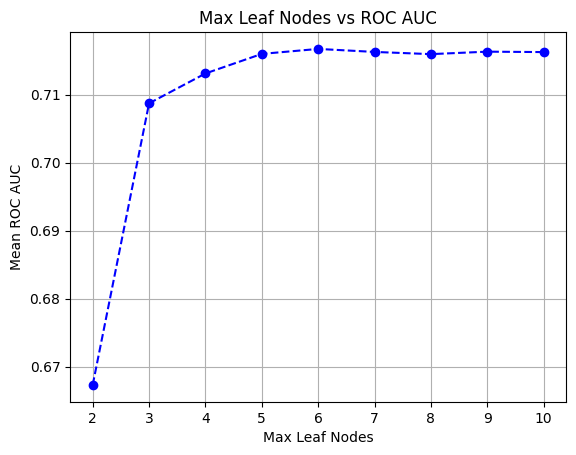

In [114]:
import matplotlib.pyplot as plt

# Plot ROC AUC scores vs max_leaf_nodes values
leaf_nodes, auc_scores = zip(*results)

plt.plot(leaf_nodes, auc_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Mean ROC AUC')
plt.title('Max Leaf Nodes vs ROC AUC')
plt.grid(True)
plt.show()

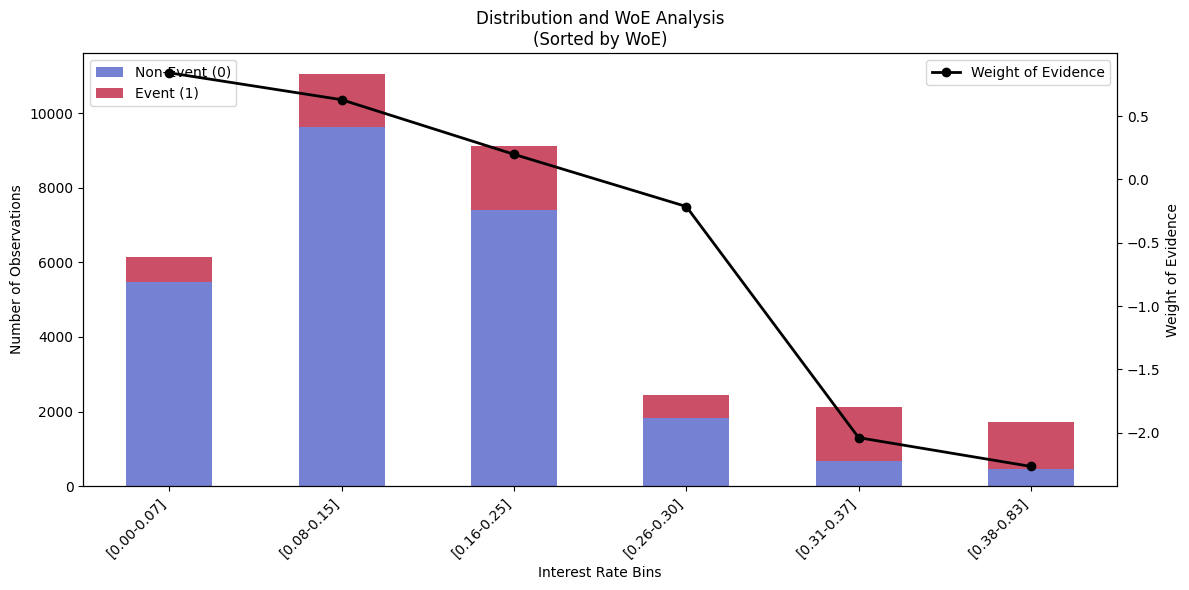

In [115]:
# Create the binned feature
df_binned, bin_statistics, reverse_mapping = create_binned_feature(
    df, 
    feature='loan_percent_income', 
    target='loan_status',
    max_leaf_nodes=6
)

# Calculate and plot WoE with sorted bins
woe_summary, iv = calculate_woe(
    df_binned, 
    feature='bin_label',
    target='loan_status', 
    plot=True,
    figsize=(12, 6),
    bin_stats=bin_statistics,
    reverse_mapping=reverse_mapping
)

#### Optimal binning

In [107]:
optbinner = OptimalBinning(name="loan_percent_income", dtype="numerical")

optbinner.fit(df['loan_percent_income'], df['loan_status'])

df['binned'] = optbinner.transform(df['loan_percent_income'], metric="bins")

bin_mapping = {bin_: f'Bin {i}' for i, bin_ in enumerate(natsorted(df['binned'].unique()))}
df['bin'] = df['binned'].map(bin_mapping)

df.groupby(['binned', 'bin'])['loan_percent_income'].agg(['min', 'max', 'mean', 'count']).sort_values(by='mean')

,,min,max,mean,count
binned,bin,,,,
"(-inf, 0.05)",Bin 0,0.00,0.05,0.037697,3452
"[0.05, 0.07)",Bin 1,0.06,0.07,0.065196,2683
"[0.07, 0.13)",Bin 2,0.08,0.13,0.104891,8505
"[0.13, 0.16)",Bin 3,0.14,0.15,0.144925,2550
"[0.16, 0.18)",Bin 4,0.16,0.17,0.165364,2347
"[0.18, 0.20)",Bin 5,0.18,0.20,0.190355,3013
"[0.20, 0.25)",Bin 6,0.21,0.25,0.229150,3751
"[0.25, 0.31)",Bin 7,0.26,0.30,0.279293,2446
"[0.31, 0.38)",Bin 8,0.31,0.37,0.335735,2110


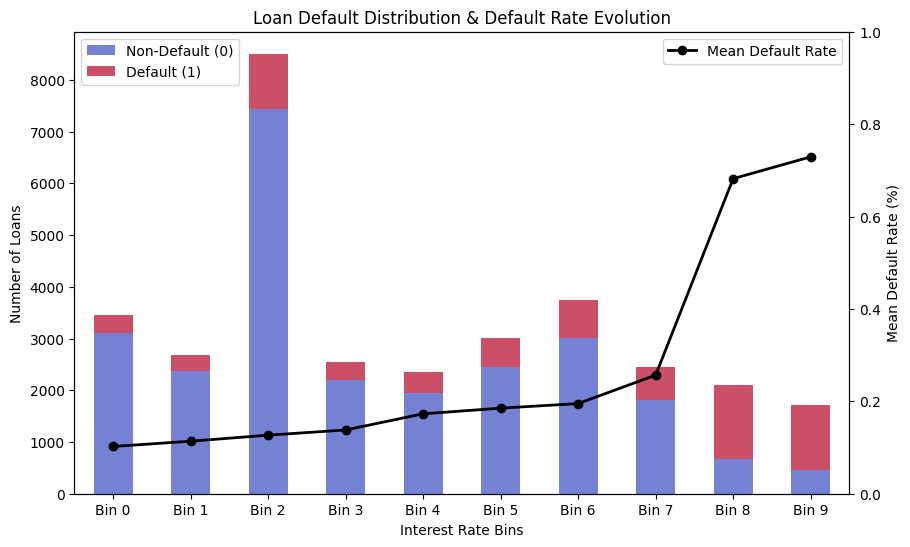

In [108]:
# Group by bins to count defaults vs. non-defaults
bin_counts = df.groupby(['bin', 'loan_status']).size().unstack(fill_value=0)

# Calculate mean default rate per bin
bin_default_rate = df.groupby('bin')['loan_status'].mean()

# Sort by bin order
bin_counts = bin_counts.loc[natsorted(bin_counts.index)]
bin_default_rate = bin_default_rate.loc[natsorted(bin_default_rate.index)]

# 🔹 PLOTTING 🔹
fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar plot for default & non-default counts
bin_counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
ax1.set_xlabel("Interest Rate Bins")
ax1.set_ylabel("Number of Loans")
ax1.set_title("Loan Default Distribution & Default Rate Evolution")

# Create a second y-axis for default rate
ax2 = ax1.twinx()
ax2.plot(bin_default_rate.index, bin_default_rate.values, marker='o', color='black', linestyle='-', linewidth=2, label="Mean Default Rate")

ax2.set_ylabel("Mean Default Rate (%)")
ax2.set_ylim(0, 1)  # Default rate is between 0 and 1

# Show legend
ax1.legend(["Non-Default (0)", "Default (1)"], loc="upper left")
ax2.legend(loc="upper right")

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
plt.show()

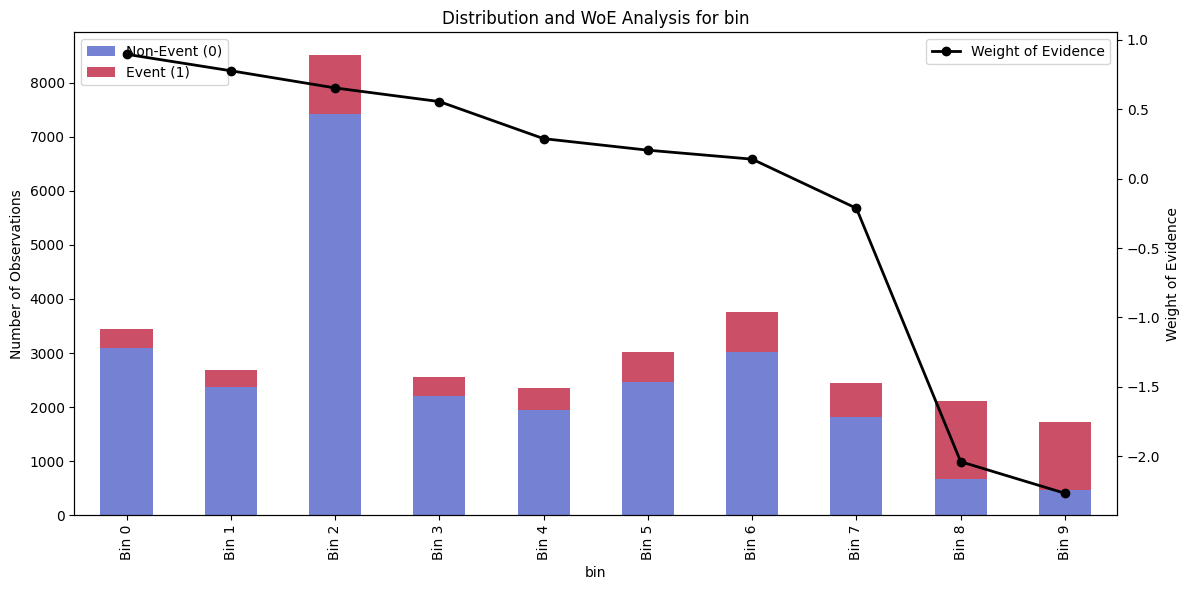

In [109]:
woe_summary, iv = metrics.calculate_woe(df, 'bin', 'loan_status', plot=True)